# Task 4: Predicting House Prices Using the Boston Housing Dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# DATASET 

In [6]:
# 1. Load and preprocess the data
df = pd.read_csv("Boston Houseing Dataset.csv")
X = df[["RM", "LSTAT", "PTRATIO"]].values
y = df["MEDV"].values

In [7]:
# Train Test
np.random.seed(42)
idx = np.random.permutation(len(X))
train_n = int(0.8 * len(X))
tr, te = idx[:train_n], idx[train_n:]
X_train, X_test = X[tr], X[te]
y_train, y_test = y[tr], y[te]

# Models From Scratch


In [8]:
# Custom scaler
class StandardScalerScratch:
    def fit(self, X):
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.scale_[self.scale_ == 0] = 1.0
    def transform(self, X):
        return (X - self.mean_) / self.scale_
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

scaler = StandardScalerScratch()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Linear Regression from scratch
class LinearRegressionScratch:
    def __init__(self, lr=0.01, n_iters=5000):
        self.lr = lr
        self.n_iters = n_iters

    def fit(self, X, y):
        n_samples, n_feats = X.shape
        self.w = np.zeros(n_feats)
        self.b = 0.0
        for _ in range(self.n_iters):
            y_pred = X.dot(self.w) + self.b
            dw = (1/n_samples) * X.T.dot(y_pred - y)
            db = (1/n_samples) * np.sum(y_pred - y)
            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict(self, X):
        return X.dot(self.w) + self.b

lin = LinearRegressionScratch()
lin.fit(X_train, y_train)
y_pred_lr = lin.predict(X_test)

In [14]:
# Decision Tree for use in RF & GB
class TreeNode:
    def __init__(self, feature=None, thr=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.thr = thr
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeRegressorScratch:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X, y, depth=0):
        # stopping criteria
        if depth >= self.max_depth or len(y) < self.min_samples_split or np.all(y == y[0]):
            return TreeNode(value=y.mean())

        best_mse = np.inf
        best_feat = best_thr = None
        n_samples, n_feats = X.shape

        # find best split
        for feat in range(n_feats):
            for thr in np.unique(X[:, feat]):
                left_idx = X[:, feat] <= thr
                right_idx = ~left_idx
                if left_idx.sum() == 0 or right_idx.sum() == 0:
                    continue
                y_l, y_r = y[left_idx], y[right_idx]
                mse_l = y_l.var() * len(y_l)
                mse_r = y_r.var() * len(y_r)
                if mse_l + mse_r < best_mse:
                    best_mse, best_feat, best_thr = mse_l + mse_r, feat, thr

        if best_feat is None:
            return TreeNode(value=y.mean())

        left = self.fit(X[X[:, best_feat] <= best_thr], y[X[:, best_feat] <= best_thr], depth+1)
        right= self.fit(X[X[:, best_feat] >  best_thr], y[X[:, best_feat] >  best_thr], depth+1)
        return TreeNode(feature=best_feat, thr=best_thr, left=left, right=right)

    def fit_tree(self, X, y):
        self.tree_ = self.fit(X, y)

    def _predict_row(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.thr:
            return self._predict_row(x, node.left)
        else:
            return self._predict_row(x, node.right)

    def predict(self, X):
        return np.array([self._predict_row(x, self.tree_) for x in X])

In [15]:
# Random Forest from scratch
class RandomForestRegressorScratch:
    def __init__(self, n_estimators=20, max_depth=5, min_samples_split=2, max_feats='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_feats = max_feats
        self.trees = []

    def fit(self, X, y):
        n_samples, n_feats = X.shape
        k = int(np.sqrt(n_feats)) if self.max_feats == 'sqrt' else n_feats
        for _ in range(self.n_estimators):
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            feat_idxs = np.random.choice(n_feats, k, replace=False)
            tree = DecisionTreeRegressorScratch(max_depth=self.max_depth,
                                                min_samples_split=self.min_samples_split)
            tree.fit_tree(X[idxs][:, feat_idxs], y[idxs])
            tree.feat_idxs = feat_idxs
            self.trees.append(tree)

    def predict(self, X):
        preds = np.array([t.predict(X[:, t.feat_idxs]) for t in self.trees])
        return preds.mean(axis=0)

rf = RandomForestRegressorScratch()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [21]:
# XGBoost-like Gradient Boosting from scratch
class XGBoostScratch:
    def __init__(self, n_estimators=20, learning_rate=0.1, max_depth=3, min_samples_split=2):
        self.n_estimators = n_estimators
        self.lr = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def fit(self, X, y):
        self.F0 = y.mean()
        Fm = np.full_like(y, self.F0, dtype=float)
        for _ in range(self.n_estimators):
            residual = y - Fm
            tree = DecisionTreeRegressorScratch(max_depth=self.max_depth,
                                                min_samples_split=self.min_samples_split)
            tree.fit_tree(X, residual)
            update = tree.predict(X)
            Fm += self.lr * update
            self.trees.append(tree)

    def predict(self, X):
        Fm = np.full((len(X),), self.F0, dtype=float)
        for t in self.trees:
            Fm += self.lr * t.predict(X)
        return Fm

xgb = XGBoostScratch()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)




# Visualization

In [ ]:
# Performance Comparison
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

def r2(a, b):
    return 1 - np.sum((a - b)**2) / np.sum((a - a.mean())**2)

results = pd.DataFrame({
    "Model": ["Linear Scratch", "Random Forest Scratch", "XGBoost Scratch"],
    "RMSE": [rmse(y_test, y_pred_lr), rmse(y_test, y_pred_rf), rmse(y_test, y_pred_xgb)],
    "R²":   [r2(y_test, y_pred_lr),   r2(y_test, y_pred_rf),   r2(y_test, y_pred_xgb)]
})
from IPython.display import display
display(results)

,Model,RMSE,R²
0,Linear Scratch,77894.663353,0.752681
1,Random Forest Scratch,76460.271198,0.761705
2,XGBoost Scratch,61115.177685,0.847756


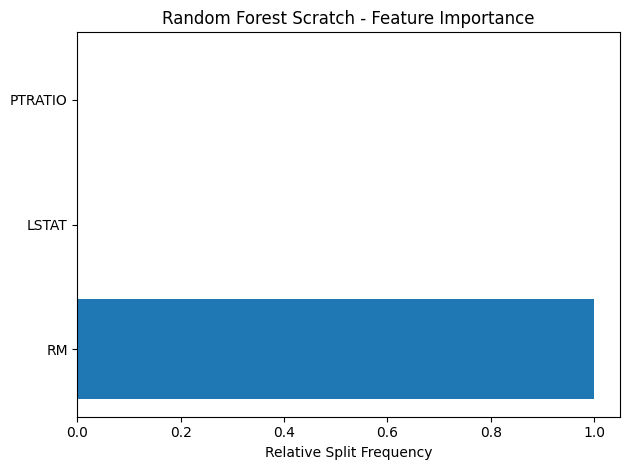

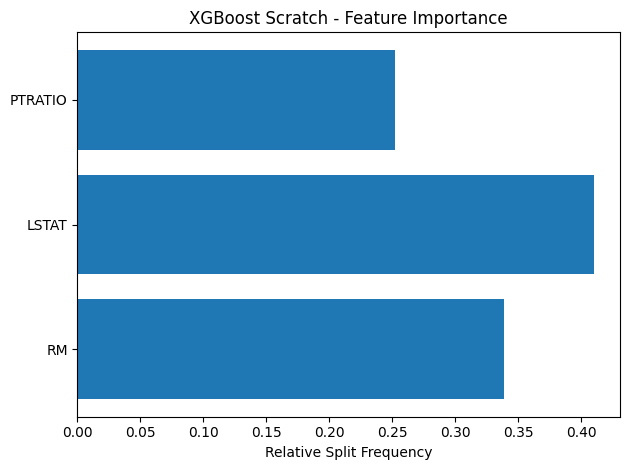

In [20]:
# Feature Importance (frequency of splits)
feature_names = ["RM", "LSTAT", "PTRATIO"]

def count_splits(tree, counts):
    if tree.feature is None:
        return
    counts[tree.feature] += 1
    count_splits(tree.left, counts)
    count_splits(tree.right, counts)

# Random Forest importance
rf_counts = np.zeros(len(feature_names))
for t in rf.trees:
    count_splits(t.tree_, rf_counts)
rf_importance = rf_counts / rf_counts.sum()

plt.figure()
plt.barh(feature_names, rf_importance)
plt.xlabel("Relative Split Frequency")
plt.title("Random Forest Scratch - Feature Importance")
plt.tight_layout()
plt.show()

# XGBoost importance
xgb_counts = np.zeros(len(feature_names))
for t in xgb.trees:
    count_splits(t.tree_, xgb_counts)
xgb_importance = xgb_counts / xgb_counts.sum()

plt.figure()
plt.barh(feature_names, xgb_importance)
plt.xlabel("Relative Split Frequency")
plt.title("XGBoost Scratch - Feature Importance")
plt.tight_layout()
plt.show()